In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [47]:
# Read the CSV file
df = pd.read_csv('costsensitiveregression.csv')

# apply log transform and add 1 to avoid log(0) to FNC column
# df['FNC'] = np.log(df['FNC'] + 1)

# Separate the independent variables (X) and the dependent variable (y)
X = df.iloc[:, :11]
y = df.iloc[:, 11:13]

# Dropping the YesCount column as it is correlated to NoCount
X.drop('YesCount', axis=1, inplace=True)

print("X Column types:\n", X.dtypes)
print("Y Column types:\n", y.dtypes)

# print the frequency of Status values from df
print("Frequency counts of Status:\n", df['Status'].value_counts())

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# Pretty print all the shapes in one line
print("X_train: ", X_train.shape, "y_train: ", y_train.shape, "X_val: ", X_val.shape, "y_val: ", y_val.shape, "X_test: ", X_test.shape, "y_test: ", y_test.shape)

# Create a custom dataset
class CSLogRegDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader objects for training and testing
train_dataset = CSLogRegDataset(X_train, y_train)
val_dataset = CSLogRegDataset(X_val, y_val)
test_dataset = CSLogRegDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


X Column types:
 NotCount      int64
ATPM        float64
PFD         float64
PFG         float64
SFD         float64
SFG         float64
WP          float64
WS          float64
AH          float64
AN          float64
dtype: object
Y Column types:
 Status      int64
FNC       float64
dtype: object
Frequency counts of Status:
 0    103554
1     44082
Name: Status, dtype: int64
X_train:  torch.Size([103345, 10]) y_train:  torch.Size([103345, 2]) X_val:  torch.Size([22145, 10]) y_val:  torch.Size([22145, 2]) X_test:  torch.Size([22146, 10]) y_test:  torch.Size([22146, 2])


In [48]:
# Describe the FNC column
fnc_df = df['FNC']
fnc_df = fnc_df.round().astype(int)
# describe the fnc_df
print(fnc_df.describe())

count    1.476360e+05
mean     5.333955e+02
std      8.774013e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.200000e+01
75%      1.070000e+02
max      1.703186e+06
Name: FNC, dtype: float64


In [17]:
# # make scatter plot of the new_df
# # tmp_df is first 1000 rows of new_df
# tmp_df = fnc_df[10000:140000]
# plt.scatter(tmp_df.index, tmp_df)

# plt.show()

# # fit fnc_df to a normal distribution
# from scipy.stats import norm
# mu, std = norm.fit(fnc_df)
# print(mu, std)

# # plot the histogram of fnc_df
# plt.figure(figsize=(10, 6))
# plt.hist(fnc_df, bins=25, density=True, alpha=0.6, color='g')

# # plot the PDF of the normal distribution
# xmin, xmax = plt.xlim()
# print(xmin, xmax)
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
# # plt.xlim(-1, 140000)
# plt.show()


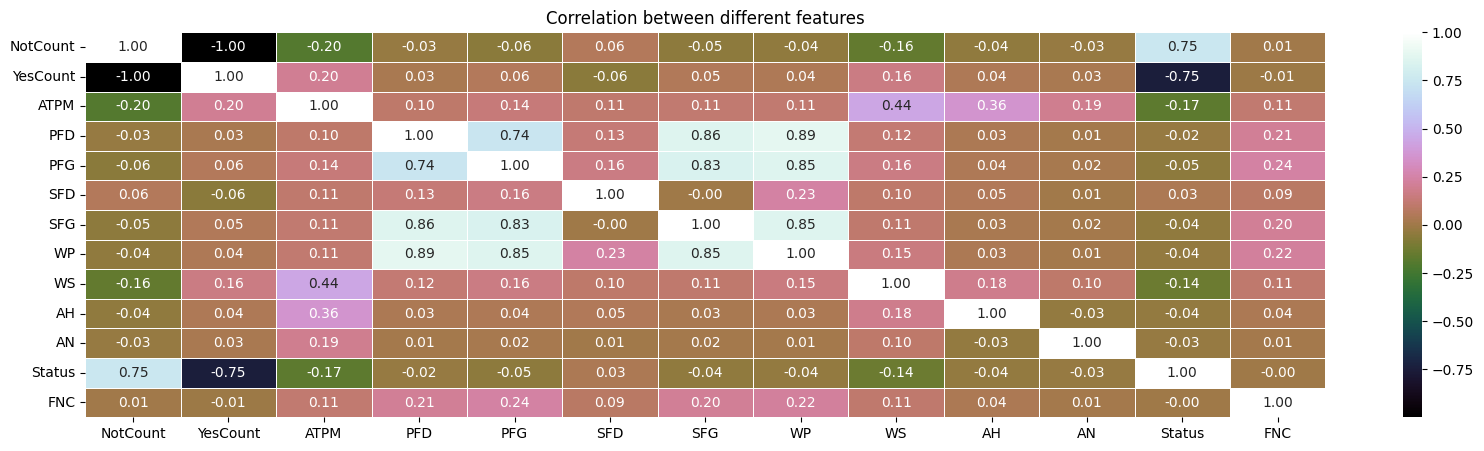

In [18]:
correlation_train = df.corr("pearson")
# plot correlation_train
fig = plt.figure(figsize=(20, 5))
sns.heatmap(correlation_train, vmax=1, annot=True, cmap='cubehelix', annot_kws={'size': 10}, fmt='.2f', linewidths=.5)
plt.title('Correlation between different features')
plt.show()
plt.close()

In [6]:
class CostSensitiveLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(CostSensitiveLogisticRegression, self).__init__()   
        # Defining the number of input features
        self.input_dim = input_dim
        # Defining the number of output features
        self.output_dim = 1
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        return out


    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.compute_loss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            # self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)               
            

            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
            
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
        
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
                
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    

In [55]:
cost_sensitive_log_model = CostSensitiveLogisticRegression(input_dim=X_train.shape[1])
return_val = cost_sensitive_log_model.train_model(train_loader, val_loader, num_epochs=10, learning_rate=0.001)

print("Cost of Cost Sensitive Logistic Regression Model: ", cost_sensitive_log_model.compute_expected_cost(test_loader))

# Display confusion matrix
y_pred = cost_sensitive_log_model(X_test)
y_pred = y_pred >= 0.5
y_pred = y_pred.detach().numpy()
y_pred = y_pred.astype(int)

# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

# convert y_pred and y_test into list
y_pred = y_pred.tolist()
# y_test = y_test.tolist()
# print precision, recall, f1 score
print(classification_report(y_test_label, y_pred))

# print accuracy
print("Accuracy: ", accuracy_score(y_test_label, y_pred))

Epoch: 1 	Training Loss: 34.191750 	Training Accuracy: 0.556031 	Validation Loss: 9.265853 	Validation Accuracy: 0.565636
Epoch: 2 	Training Loss: 9.083587 	Training Accuracy: 0.563288 	Validation Loss: 6.101546 	Validation Accuracy: 0.574080
Epoch: 3 	Training Loss: 6.593215 	Training Accuracy: 0.569249 	Validation Loss: 4.854788 	Validation Accuracy: 0.577918
Epoch: 4 	Training Loss: 5.352231 	Training Accuracy: 0.574667 	Validation Loss: 4.288415 	Validation Accuracy: 0.581260
Epoch: 5 	Training Loss: 4.788876 	Training Accuracy: 0.574629 	Validation Loss: 3.987477 	Validation Accuracy: 0.583382
Epoch: 6 	Training Loss: 4.241205 	Training Accuracy: 0.587972 	Validation Loss: 3.577351 	Validation Accuracy: 0.595078
Epoch: 7 	Training Loss: 3.898595 	Training Accuracy: 0.593691 	Validation Loss: 3.499646 	Validation Accuracy: 0.596297
Epoch: 8 	Training Loss: 3.735347 	Training Accuracy: 0.596062 	Validation Loss: 3.421894 	Validation Accuracy: 0.599503
Epoch: 9 	Training Loss: 3.5996

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        # Defining the number of input features
        self.input_dim = input_dim
        # Defining the number of output features
        self.output_dim = 1
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )
        self.loss_critetion = nn.BCELoss()
        
    def forward(self, x):
        out = self.model(x)
        return out
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.loss_critetion
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # print('Batch: ', batch_idx)
                # print(data.shape)
                # print(target.shape)
                target = target[:, 0].view(-1, 1)
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
    
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
        
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
            
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
            
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    

In [51]:
log_model = LogisticRegression(input_dim=X_train.shape[1])
return_val = log_model.train_model(train_loader, val_loader, num_epochs=10, learning_rate=0.001)
print("Cost of Logistic Regression Model: ", log_model.compute_expected_cost(test_loader))

# Display confusion matrix
y_pred = log_model(X_test)
y_pred = y_pred >= 0.5
y_pred = y_pred.detach().numpy()
y_pred = y_pred.astype(int)

# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

# convert y_pred and y_test into list
y_pred = y_pred.tolist()
# y_test = y_test.tolist()
# print precision, recall, f1 score
print(classification_report(y_test_label, y_pred))

# print accuracy
print("Accuracy: ", accuracy_score(y_test_label, y_pred))


Epoch: 1 	Training Loss: 0.395643 	Training Accuracy: 0.841928 	Validation Loss: 0.311979 	Validation Accuracy: 0.866200
Epoch: 2 	Training Loss: 0.307816 	Training Accuracy: 0.866496 	Validation Loss: 0.308780 	Validation Accuracy: 0.865974
Epoch: 3 	Training Loss: 0.307126 	Training Accuracy: 0.866428 	Validation Loss: 0.308638 	Validation Accuracy: 0.866019
Epoch: 4 	Training Loss: 0.306900 	Training Accuracy: 0.866534 	Validation Loss: 0.308384 	Validation Accuracy: 0.865794
Epoch: 5 	Training Loss: 0.306849 	Training Accuracy: 0.866670 	Validation Loss: 0.308209 	Validation Accuracy: 0.865884
Epoch: 6 	Training Loss: 0.306766 	Training Accuracy: 0.866331 	Validation Loss: 0.308220 	Validation Accuracy: 0.866381
Epoch: 7 	Training Loss: 0.306703 	Training Accuracy: 0.866670 	Validation Loss: 0.308156 	Validation Accuracy: 0.865884
Epoch: 8 	Training Loss: 0.306680 	Training Accuracy: 0.866457 	Validation Loss: 0.307915 	Validation Accuracy: 0.866336
Epoch: 9 	Training Loss: 0.30660

In [10]:
# Class for Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralNetwork, self).__init__()
        # Defining the number of input nodes, hidden nodes and output nodes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = 1
        # Defining the layers
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        )

        self.loss_critetion = nn.BCELoss()
        
    def forward(self, x):
        # Forward pass through the network
        x = self.model(x)
        return x
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss

    def compute_expected_cost(self, test_loader):
        self.eval()
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    def train_model(self, train_loader, test_loader, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.loss_critetion
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):

                target = target[:, 0].view(-1, 1)
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
    
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
        
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
            
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
            
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    

In [52]:
neural_network_model = NeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
return_val = neural_network_model.train_model(train_loader, val_loader, num_epochs=10, learning_rate=0.001)
print("Cost of NN Model: ", neural_network_model.compute_expected_cost(test_loader))

# Display confusion matrix
y_pred = neural_network_model(X_test)
y_pred = y_pred >= 0.5
y_pred = y_pred.detach().numpy()
y_pred = y_pred.astype(int)

# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

# convert y_pred and y_test into list
y_pred = y_pred.tolist()
# y_test = y_test.tolist()
# print precision, recall, f1 score
print(classification_report(y_test_label, y_pred))

# print accuracy
print("Accuracy: ", accuracy_score(y_test_label, y_pred))

Epoch: 1 	Training Loss: 0.330601 	Training Accuracy: 0.859761 	Validation Loss: 0.304615 	Validation Accuracy: 0.865432
Epoch: 2 	Training Loss: 0.298885 	Training Accuracy: 0.865964 	Validation Loss: 0.297793 	Validation Accuracy: 0.866019
Epoch: 3 	Training Loss: 0.294928 	Training Accuracy: 0.866776 	Validation Loss: 0.295712 	Validation Accuracy: 0.866290
Epoch: 4 	Training Loss: 0.293310 	Training Accuracy: 0.866680 	Validation Loss: 0.294181 	Validation Accuracy: 0.866290
Epoch: 5 	Training Loss: 0.292167 	Training Accuracy: 0.866834 	Validation Loss: 0.294906 	Validation Accuracy: 0.866561
Epoch: 6 	Training Loss: 0.291547 	Training Accuracy: 0.867047 	Validation Loss: 0.293744 	Validation Accuracy: 0.866787
Epoch: 7 	Training Loss: 0.291053 	Training Accuracy: 0.867376 	Validation Loss: 0.293817 	Validation Accuracy: 0.867374
Epoch: 8 	Training Loss: 0.290609 	Training Accuracy: 0.867154 	Validation Loss: 0.292402 	Validation Accuracy: 0.866561
Epoch: 9 	Training Loss: 0.29013

In [12]:
# Cost Sensitive Neural Network Model
class CostSensitiveNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CostSensitiveNeuralNetwork, self).__init__()
        # Defining the number of input nodes, hidden nodes and output nodes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = 1
                # Defining the layers
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        self.loss_critetion = self.compute_loss
    
    def forward(self, x):
        # Forward pass through the network
        x = self.model(x)
        return x
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.compute_loss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)               
            
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
            
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
        
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
                
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
        

In [53]:
cost_sensitive_nn = CostSensitiveNeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
return_val = cost_sensitive_nn.train_model(train_loader, test_loader, num_epochs=10, learning_rate=0.001)
print("Cost of Cost Sensitive Neural Network: ", cost_sensitive_nn.compute_expected_cost(test_loader))

# Display confusion matrix
y_pred = cost_sensitive_nn(X_test)
y_pred = y_pred >= 0.5
y_pred = y_pred.detach().numpy()
y_pred = y_pred.astype(int)

# select only first column of y_test
y_test_label = []
for i in range(len(y_test)):
    y_test_label.append(y_test[i][0])

# convert y_pred and y_test into list
y_pred = y_pred.tolist()
# y_test = y_test.tolist()
# print precision, recall, f1 score
print(classification_report(y_test_label, y_pred))

# print accuracy
print("Accuracy: ", accuracy_score(y_test_label, y_pred))

Epoch: 1 	Training Loss: 9.026176 	Training Accuracy: 0.301834 	Validation Loss: 3.573717 	Validation Accuracy: 0.297074
Epoch: 2 	Training Loss: 3.477487 	Training Accuracy: 0.542465 	Validation Loss: 2.759674 	Validation Accuracy: 0.665944
Epoch: 3 	Training Loss: 2.785147 	Training Accuracy: 0.668218 	Validation Loss: 2.673012 	Validation Accuracy: 0.652036
Epoch: 4 	Training Loss: 2.644423 	Training Accuracy: 0.666496 	Validation Loss: 2.646624 	Validation Accuracy: 0.654339
Epoch: 5 	Training Loss: 2.602388 	Training Accuracy: 0.667067 	Validation Loss: 2.632211 	Validation Accuracy: 0.656371
Epoch: 6 	Training Loss: 2.578712 	Training Accuracy: 0.670182 	Validation Loss: 2.619107 	Validation Accuracy: 0.661293
Epoch: 7 	Training Loss: 2.830965 	Training Accuracy: 0.673695 	Validation Loss: 2.600717 	Validation Accuracy: 0.670821
Epoch: 8 	Training Loss: 3.058951 	Training Accuracy: 0.678369 	Validation Loss: 2.595115 	Validation Accuracy: 0.666712
Epoch: 9 	Training Loss: 2.56871